In [172]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [151]:
conn = duckdb.connect('../warehouse/nyc_taxi.duckdb')

In [152]:
data = conn.execute("""
SELECT * FROM daily_taxi_metrics ORDER BY trip_date
""").df()

In [153]:
conn.close()

In [154]:
data.head()

,trip_date,total_trips,avg_trip_distance,avg_trip_duration_min,avg_fare,total_revenue
0,2022-01-01,62835,5.97,12.70,21.21,1332847.16
1,2022-01-02,57918,6.24,13.42,23.00,1332373.38
2,2022-01-03,71812,7.74,12.55,21.11,1515922.91
3,2022-01-04,74018,3.47,12.51,19.98,1479041.47
4,2022-01-05,74043,5.94,12.56,19.51,1444747.09


In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   trip_date              90 non-null     datetime64[us]
 1   total_trips            90 non-null     int64         
 2   avg_trip_distance      90 non-null     float64       
 3   avg_trip_duration_min  90 non-null     float64       
 4   avg_fare               90 non-null     float64       
 5   total_revenue          90 non-null     float64       
dtypes: datetime64[us](1), float64(4), int64(1)
memory usage: 4.3 KB


In [156]:
#Create time based features
data['day_of_week'] = data['trip_date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5,6]).astype(int)
data['week'] = data['trip_date'].dt.isocalendar().week
data['month'] = data['trip_date'].dt.month

In [157]:
#Create lag features
data['lag_1'] = data['total_trips'].shift(1)
data['lag_7'] = data['total_trips'].shift(7)
data['lag_14'] = data['total_trips'].shift(14)

In [158]:
data = data.dropna().reset_index(drop=True)

In [159]:
#Time series forecasting
features = [
    'day_of_week',
    'is_weekend',
    'week',
    'month',
    'lag_1',
    'lag_7',
    'lag_14',
]

X = data[features]
y = data['total_trips']

In [160]:
import lightgbm as lgbm

In [161]:
split_date = '2022-03-15'

train = data[data_fe['trip_date'] < split_date]
test = data[data_fe['trip_date'] >= split_date]

X_train = train[features]
y_train = train['total_trips']

X_test = test[features]
y_test = test['total_trips']

In [162]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

In [163]:
train_data = lgbm.Dataset(X_train, label=y_train)
valid_data = lgbm.Dataset(X_test, label=y_test)

model = lgbm.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, valid_data],
    valid_names=["train","valid"],
    callbacks=[
        lgbm.early_stopping(100),
        lgbm.log_evaluation(100)
    ]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 59, number of used features: 7
[LightGBM] [Info] Start training from score 101135.593220
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [164]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [165]:
#Evaluate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")

MAE: 2,915
RMSE: 3,738


Text(0.5, 1.0, 'Feature Importance (Gain)')

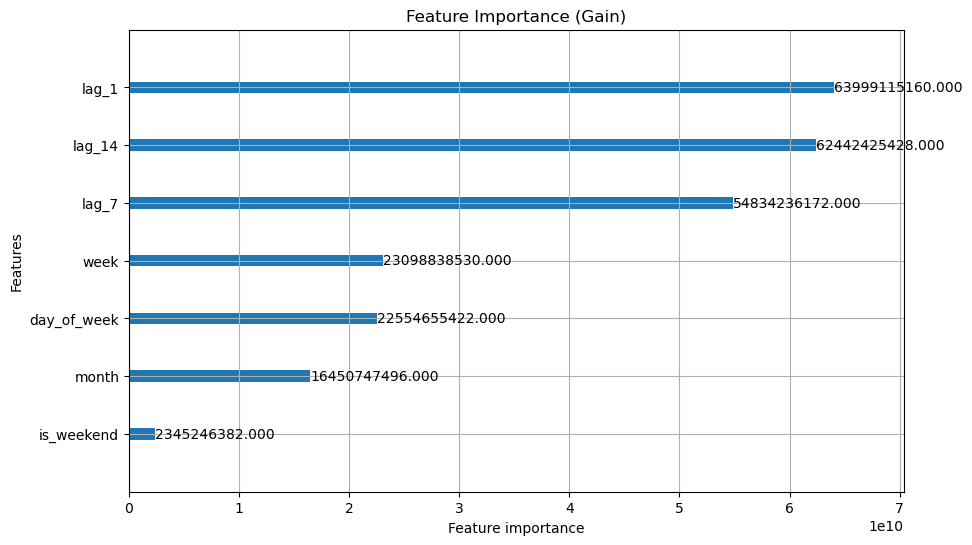

In [166]:
lgbm.plot_importance(
    model,
    importance_type='gain',
    max_num_features=15,
    figsize=(10, 6)
)

plt.title("Feature Importance (Gain)")

In [167]:
for h in [1, 3, 7, 14]:
    data[f'y_{h}'] = data_fe['total_trips'].shift(-h)

In [168]:
def expanding_window_split(X, y, initial_train_size):
    splits = []
    for i in range(initial_train_size, len(X)):
        X_train = X.iloc[:i]
        y_train = y.iloc[:i]
        X_test  = X.iloc[i:i+1]
        y_test  = y.iloc[i:i+1]
        splits.append((X_train, X_test, y_train, y_test))
    return splits

In [169]:
h = 1
target = f'y_{h}'

data_model = data.dropna().copy()

X = data_model[features]
y = data_model[target]

splits = expanding_window_split(X, y, initial_train_size=60)

preds = []
actuals = []

for i, (X_train, X_test, y_train, y_test) in enumerate(splits):

    train_data = lgbm.Dataset(X_train, label=y_train)

    model = lgbm.train(
        params,
        train_data,
        num_boost_round=500,
    )

    pred = model.predict(X_test)[0]

    preds.append(pred)
    actuals.append(y_test.values[0])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 60, number of used features: 7
[LightGBM] [Info] Start training from score 101827.850000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [170]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae  = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 4383.48
RMSE: 5475.74


Text(0.5, 1.0, 'Walk-Forward Forecast Performance')

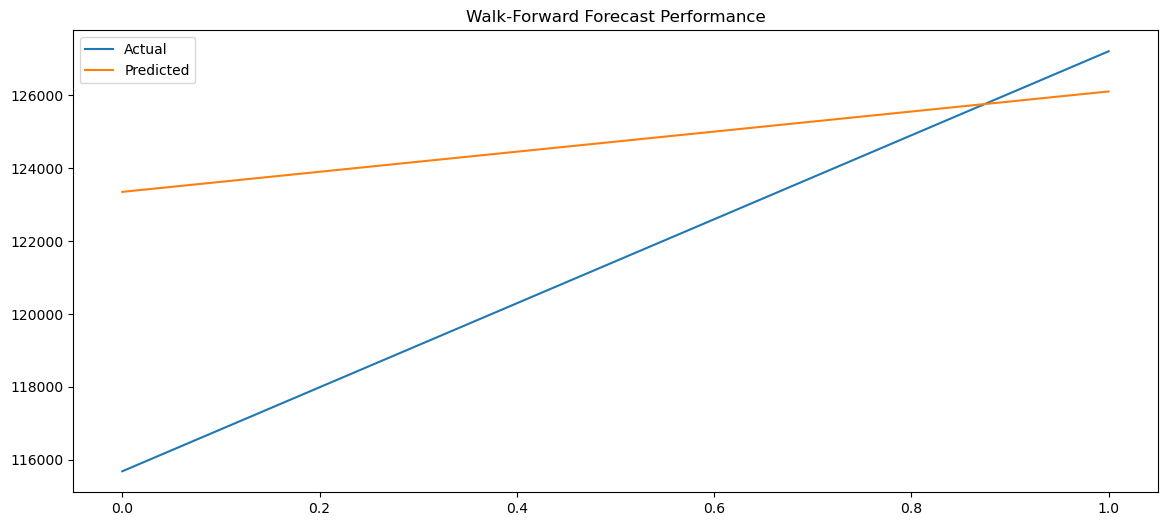

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(actuals, label='Actual')
plt.plot(preds, label='Predicted')
plt.legend()
plt.title('Walk-Forward Forecast Performance')

In [173]:
horizons = [1,3,7,14]
results = []

for h in horizons:
    target = f'y_{h}'
    data_model = data.dropna().copy()

    X = data_model[features]
    y = data_model[target]

    splits = expanding_window_split(X, y, initial_train_size=50)

    preds, actuals = [], []

    for X_train, X_test, y_train, y_test in splits:
        train_data = lgbm.Dataset(X_train, label=y_train)

        model = lgbm.train(
            params,
            train_data,
            num_boost_round=500
        )

        pred = model.predict(X_test)[0]
        preds.append(pred)
        actuals.append(y_test.values[0])

    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))

    results.append([h, mae, rmse])

results_df = pd.DataFrame(results, columns=['Horizon (days)', 'MAE', 'RMSE'])
results_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 75
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 7
[LightGBM] [Info] Start training from score 99475.540000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,Horizon (days),MAE,RMSE
0,1,4737.355210,6684.904485
1,3,4296.769080,5555.490518
2,7,4449.892527,5416.582437
3,14,4263.707431,5026.966320


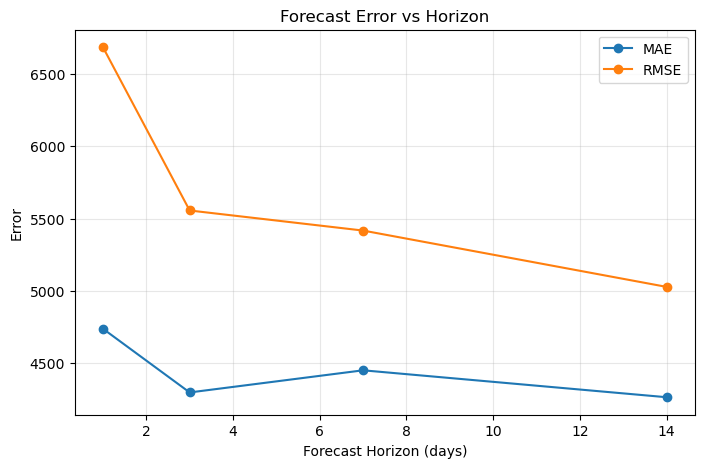

In [174]:
plt.figure(figsize=(8,5))
plt.plot(results_df['Horizon (days)'], results_df['MAE'], marker='o', label='MAE')
plt.plot(results_df['Horizon (days)'], results_df['RMSE'], marker='o', label='RMSE')
plt.xlabel('Forecast Horizon (days)')
plt.ylabel('Error')
plt.title('Forecast Error vs Horizon')
plt.legend()
plt.grid(alpha=0.3)

In [191]:
final_forecasts = {}

for h in horizons:
    target = f'y_{h}'
    data_model = data.dropna().copy()

    X = data_model[features]
    y = data_model[target]

    train_data = lgbm.Dataset(X, label=y)

    model = lgbm.train(
        params,
        train_data,
        num_boost_round=500
    )

    X_latest = X.iloc[[-1]]
    forecast = model.predict(X_latest)[0]

    final_forecasts[f'T+{h} days'] = forecast

forecast_df = pd.DataFrame([final_forecasts])
forecast_df

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.227570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 62, number of used features: 7
[LightGBM] [Info] Start training from score 102460.661290
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,T+1 days,T+3 days,T+7 days,T+14 days
0,127348.14761,99078.7483,121017.190961,125759.127225


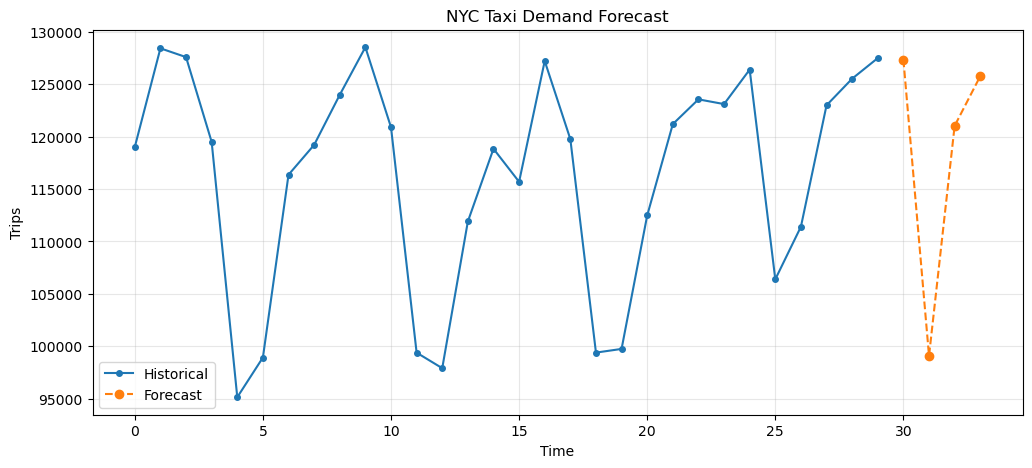

In [192]:
last_actual = data['total_trips'].iloc[-30:]

plt.figure(figsize=(12,5))
plt.plot(last_actual.values, label='Historical', marker='o', markersize=4)

future_vals = list(final_forecasts.values())
plt.plot(range(len(last_actual), len(last_actual)+len(future_vals)), 
         future_vals, marker='o', linestyle='--', label='Forecast')

plt.title('NYC Taxi Demand Forecast')
plt.xlabel('Time')
plt.ylabel('Trips')
plt.legend()
plt.grid(alpha=0.3)

In [188]:
#Export data
conn = duckdb.connect('../warehouse/nyc_taxi.duckdb')

conn.execute("""
COPY daily_taxi_metrics
TO 'daily_taxi_metrics.csv'
(FORMAT CSV, HEADER, DELIMITER ',');
""")

In [187]:
conn.close()

In [190]:
data

,trip_date,total_trips,avg_trip_distance,avg_trip_duration_min,avg_fare,total_revenue,day_of_week,is_weekend,week,month,lag_1,lag_7,lag_14,y_1,y_3,y_7,y_14
0,2022-01-15,88061,8.88,11.82,18.30,1611808.76,5,1,2,1,93131.0,82610.0,62835.0,72209.0,84012.0,95908.0,34155.0
1,2022-01-16,72209,4.55,11.91,19.18,1385082.38,6,1,2,1,88061.0,63561.0,57918.0,63054.0,85977.0,76371.0,70730.0
2,2022-01-17,63054,5.00,12.12,20.60,1299024.73,0,0,3,1,72209.0,73186.0,71812.0,84012.0,90189.0,77955.0,85250.0
3,2022-01-18,84012,4.96,13.20,19.14,1608238.82,1,0,3,1,63054.0,77052.0,74018.0,85977.0,100385.0,86740.0,91738.0
4,2022-01-19,85977,3.64,13.07,18.42,1583303.42,2,0,3,1,84012.0,79732.0,74043.0,90189.0,95908.0,96029.0,91949.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2022-03-27,106383,5.36,13.82,21.59,2296671.98,6,1,12,3,126385.0,99392.0,99387.0,111401.0,125520.0,NaN,NaN
72,2022-03-28,111401,4.98,14.42,20.96,2334611.49,0,0,13,3,106383.0,99744.0,97906.0,122980.0,127483.0,NaN,NaN
73,2022-03-29,122980,4.16,14.91,20.43,2513018.92,1,0,13,3,111401.0,112473.0,111898.0,125520.0,NaN,NaN,NaN
74,2022-03-30,125520,6.06,15.13,20.53,2576454.35,2,0,13,3,122980.0,121187.0,118834.0,127483.0,NaN,NaN,NaN


In [193]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [196]:
# load your daily data
df = data.copy()
df["trip_date"] = pd.to_datetime(df["trip_date"])
df = df.sort_values("trip_date")

# fit model
model = ExponentialSmoothing(
    df["total_trips"],
    trend="add",
    seasonal="add",
    seasonal_periods=7
).fit()

# forecast next 30 days
forecast = model.forecast(30)

# build forecast table
forecast_df = pd.DataFrame({
    "trip_date": pd.date_range(
        start=df["trip_date"].max() + pd.Timedelta(days=1),
        periods=30,
        freq="D"
    ),
    "forecast_total_trips": forecast.values
})

forecast_df.to_csv("forecast_total_trips.csv", index=False)